## makemore: part 5

In [36]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

#  WaveNet Explained

![WaveNet Architecture](Wavenet_img.png)

## 1. Input Layer
- The **blue circles** at the bottom are the **input samples** of the raw audio waveform.
- Each sample is processed one by one in sequence.
- Because WaveNet is **causal**, predictions only depend on past inputs (no peeking into the future).

---

## 2. Hidden Layers with Dilation
- The **white circles** represent hidden layers of 1D convolutions.
- Each hidden layer has a **dilation rate** that determines how far it "skips" when looking back:
  - **Layer 1 (Dilation = 1):** Looks at immediate past (neighboring inputs).
  - **Layer 2 (Dilation = 2):** Skips one input, looks 2 steps back.
  - **Layer 3 (Dilation = 4):** Skips three inputs, looks 4 steps back.
  - **Layer 4 (Dilation = 8):** Skips seven inputs, looks 8 steps back.

➡️ This pattern **exponentially increases the receptive field**, so the higher layers can capture long-range dependencies without needing extremely deep networks.

---

## 3. Output Layer
- The **orange circles** at the top are the **predicted output samples**.
- Each output depends only on inputs from the past, thanks to the **causal convolutions**.
- Together, all dilated layers combine local + global context.

---

## 4. Why is this powerful?
- Normal convolutions see only short windows.
- With dilation, WaveNet can cover **hundreds of past samples** with just a few layers.
- This allows it to model long-term dependencies in audio (like rhythm, tone, intonation).

---

## 5. Beginner Takeaway
Think of it like a **hierarchy of memories**:
- Lower layers remember the **immediate past**,
- Middle layers remember the **recent past**,
- Upper layers remember the **distant past**.

All combined, WaveNet can generate speech that sounds natural, because it uses **both short-term details and long-term structure** of audio.


In [37]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [38]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [39]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [40]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [41]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [54]:
Xtr.shape,  Ytr.shape

(torch.Size([182625, 8]), torch.Size([182625]))

In [42]:

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]


## 🧩 Jupyter Markdown: Explanation of the Custom Layers

This note explains what each class does in your plain-Python deep-learning stack and how tensors flow through them. It’s written for a Jupyter **Markdown** cell (rendered with MathJax).

---

### 1) `Linear` — Fully Connected Layer

**Operation**
$$
y = xW + b
$$

**Shapes**
$$
x \in \mathbb{R}^{B \times \text{fan\_in}},\quad
W \in \mathbb{R}^{\text{fan\_in} \times \text{fan\_out}},\quad
b \in \mathbb{R}^{\text{fan\_out}},\quad
y \in \mathbb{R}^{B \times \text{fan\_out}}.
$$

**Details**
- Weights are initialized with Kaiming-like scaling: \(W \sim \mathcal{N}\!\left(0,\; \frac{1}{\sqrt{\text{fan\_in}}}\right)\).
- Bias defaults to zeros (optional).
- Bias is **broadcast** row-wise across the batch.
- Gradients flow through `@` (matrix multiply) and bias add, so autograd can train \(W,b\).

**Beginner intuition:** each output feature is a weighted sum of **all** input features plus a bias.

---

### 2) `BatchNorm1d` — Batch Normalization for 2D or 3D

**Goal:** stabilize training by normalizing activations channel-wise, then re-scaling/shifting.

**Forward (training)**
For each channel \(c\):
$$
\mu_c = \mathrm{mean}(x_c),\quad
\sigma_c^2 = \mathrm{var}(x_c),\quad
\hat{x}_c = \frac{x_c - \mu_c}{\sqrt{\sigma_c^2 + \varepsilon}},\quad
y_c = \gamma_c \hat{x}_c + \beta_c .
$$

**Running stats (EMA)**
$$
\text{running\_mean} \leftarrow (1-m)\,\text{running\_mean} + m\,\mu,\qquad
\text{running\_var} \leftarrow (1-m)\,\text{running\_var} + m\,\sigma^2 .
$$

**Input shapes handled**
- If `x.ndim == 2`: normalize over **batch** → dimension `0`.
  Shape: \(x \in \mathbb{R}^{B \times C}\).
- If `x.ndim == 3`: normalize over **batch × time** → dimensions `(0, 1)`.
  Shape: \(x \in \mathbb{R}^{B \times T \times C}\).

**Parameters:** \(\gamma,\beta \in \mathbb{R}^{C}\) (trainable).
**Buffers:** `running_mean`, `running_var` (not trainable, updated each forward in training).

**Eval mode:** use running stats instead of batch stats.

**Gotcha:** set `.training = True/False` appropriately (or port to `nn.Module` to use `model.train()/eval()`).

---

### 3) `Tanh` — Nonlinearity

**Definition**
$$
\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} \in (-1,1).
$$

**Why needed?** Nonlinearities let stacked linear layers model complex, non-linear mappings.
**Note:** very large \(|x|\) saturates gradients (near \(-1\) or \(+1\)).

---

### 4) `Embedding` — Token Lookup Table

**Weights**
$$
E \in \mathbb{R}^{\text{num\_embeddings} \times \text{embedding\_dim}} .
$$

**Lookup**
Given integer indices \(I \in \mathbb{N}^{B \times T}\),
$$
X = E[I] \in \mathbb{R}^{B \times T \times \text{embedding\_dim}} .
$$

**Intuition:** turns discrete IDs into continuous vectors. Only **used rows** receive gradients each step.
**Gotcha:** input indices must be integer type (e.g., `torch.long`).

---

### 5) `FlattenConsecutive(n)` — Merge Local Context

**Shape transform**
Input \(x \in \mathbb{R}^{B \times T \times C}\) becomes
$$
x' \in \mathbb{R}^{B \times (T/n) \times (nC)} .
$$

If \((T/n) = 1\), squeeze time:
$$
x' \in \mathbb{R}^{B \times (nC)} .
$$

**Why:** successively merging neighbors (pairs → groups of 4 → 8…) gives deeper layers access to **wider local context** (hierarchical n-gram effect).

**Gotcha:** assumes \(T\) divisible by \(n\). If not, pad or trim first.

---

### 6) `Sequential` — Apply Layers in Order

**Composition**
If layers are \((\ell_1, \ell_2, \dots, \ell_K)\), then
$$
x_{k+1} = \ell_k(x_k),\quad k=1,\dots,K .
$$

**What it provides**
- A simple forward pass through a Python list of layers.
- `parameters()` flattens all sub-layer parameters into one list (helpful for manual optimization).

**Note:** these are plain Python classes (not `nn.Module`), but tensors still carry gradients, so autograd works; you just manage training/eval flags and device moves manually.

---

## 🔄 Typical Flow (Sequence Model Sketch)

1. **Embedding:** \((B, T) \to (B, T, C)\)
2. **FlattenConsecutive(2):** \((B, T, C) \to (B, T/2, 2C)\)
3. **Linear:** \((B, T/2, 2C) \to (B, T/2, H)\)
4. **BatchNorm1d + Tanh:** stabilize & add nonlinearity
5. **Repeat Flatten/Linear/BN/Tanh** to widen context
6. If \(T\) reduces to \(1\), squeeze → \((B, H)\), then **final Linear** → \((B, \text{vocab\_size})\)

**Big picture:**
- `Embedding` gives dense vectors,
- `FlattenConsecutive` widens local context,
- `Linear` transforms features,
- `BatchNorm1d` keeps activations well-behaved,
- `Tanh` adds nonlinearity,
- `Sequential` stitches it all together.


In [43]:
torch.manual_seed(42); # seed rng for reproducibility

In [44]:
# original network
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 300 # the number of neurons in the hidden layer of the MLP
# model = Sequential([
#   Embedding(vocab_size, n_embd),
#   FlattenConsecutive(8), Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])

# hierarchical network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [45]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.3167
  10000/ 200000: 2.0576
  20000/ 200000: 2.0723
  30000/ 200000: 2.5134
  40000/ 200000: 2.1476
  50000/ 200000: 1.7836
  60000/ 200000: 2.2592
  70000/ 200000: 1.9331
  80000/ 200000: 1.6875
  90000/ 200000: 2.0395
 100000/ 200000: 1.7736
 110000/ 200000: 1.9569
 120000/ 200000: 1.7465
 130000/ 200000: 1.8126
 140000/ 200000: 1.7406
 150000/ 200000: 1.7467
 160000/ 200000: 1.8805
 170000/ 200000: 1.6266
 180000/ 200000: 1.6476
 190000/ 200000: 1.8555


In [46]:
torch.tensor(lossi).view(-1, 1000).mean(1).shape

torch.Size([200])

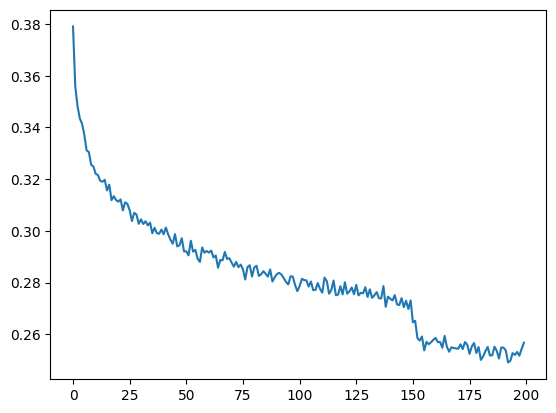

In [47]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [48]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [49]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.769028902053833
val 1.9936511516571045


### performance log

- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8 (22K params): train 1.918, val 2.027
- flat -> hierarchical (22K params): train 1.941, val 2.029
- fix bug in batchnorm: train 1.912, val 2.022
- scale up the network: n_embd 24, n_hidden 128 (76K params): train 1.769, val 1.993


In [50]:
# sample from the model
for _ in range(40):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

aiyanah.
giusopf.
lorron.
roger.
rhyitte.
christell.
jedmccee.
kelipson.
briyah.
sylot.
zennica.
mythan.
daxphon.
petrit.
adalie.
jeniyah.
glatipe.
manaswi.
yeslee.
stephania.
kharson.
anabella.
harlee.
mangels.
leamir.
benu.
swayde.
jamyly.
zaniya.
hadyya.
jamilyn.
calissa.
gresling.
zhyana.
aovene.
amirs.
jocelen.
yuvin.
uri.
ayomix.


### Next time:
Why convolutions? Brief preview/hint

In [51]:
for x,y in zip(Xtr[7:15], Ytr[7:15]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .


In [52]:
# forward a single example:
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

In [53]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
  logits[i] = model(Xtr[[7+i]])
logits.shape

torch.Size([8, 27])

In [35]:
# convolution is a "for loop"
# allows us to forward Linear layers efficiently over space